In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import gc
import os
import sklearn
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

BASE_PATH = '../input/uet-hackathon-2022-data-science'
DS_PATH = '../'
OUTPUT_PATH = f'./model/{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}'
N_FOLD = 5
SEED = 42
NOT_FOUND_RANK = 35.5

# try:
#     os.makedirs(OUTPUT_PATH)
# except:
#     pass


info_test_df: pd.DataFrame =  pd.read_csv(f'{BASE_PATH}/info_test.csv')
info_train_df: pd.DataFrame =  pd.read_csv(f'{BASE_PATH}/info_train.csv')

label_test_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/label_test.csv')
label_train_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/label_train.csv')

work_test_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/work_test.csv')
work_train_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/work_train.csv')
    
rank_df = pd.read_csv('../input/city-rank/city_rank.csv')

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
info_train_df.describe()
label_train_df.describe()
work_train_df.describe()
work_train_df[work_train_df['employee_lv'] > 7]
# work_train_df.info()

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address
1,1,113039360,106,TF2212F,-1,Giám đốc,20160100,20220400,10.0,Hà Nội
3,2,116074930,102,TB16010,-1,Nhân viên lễ tân,20170100,20170300,8.0,Hà Nội
5,2,116074930,102,TB16010,-1,Nhân viên Sales Admin,20170800,20191200,8.0,Hà Nội
6,2,116074930,102,TB16010,-1,Nhân viên Sales Admin,20200100,20200600,9.0,Việt Nam
7,2,116074930,102,TB16010,-1,NaN,20200700,20201200,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...
247547,55006,7516183730,7509,YN0168I,-1,CN Máy Ép Nhựa,20180600,20181200,8.0,Đồng Nai
247548,55006,7516183730,7509,YN0168I,-1,CÔNG NHÂN Máy Ép Nhựa,20190100,20191200,9.0,Đồng Nai
247549,55006,7516183730,7509,YN0168I,-1,CÔNG NHÂN Máy Ép Nhựa,20200100,20220400,10.0,Đồng Nai
247557,55008,2616117553,2600,TZ0085Z,1,Phụ kho,20180100,20191200,8.0,Vĩnh Phúc


In [3]:
N = 5
info_train_df.sample(N)
work_train_df.sample(N)
work_train_df.describe()

display(work_train_df[work_train_df['employee_lv'] > 200])
display(work_test_df[work_test_df['employee_lv'] > 200])

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address
9687,2341,2297041616,2705,HZ0000Z,-1,Thợ cơ khí,19980100,19980100,331.0,NaN


,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address
106441,22761,2196019940,2400,HA0031A,-1,Công Chức,19960800,19980200,369.0,NaN


-1.0 59.0


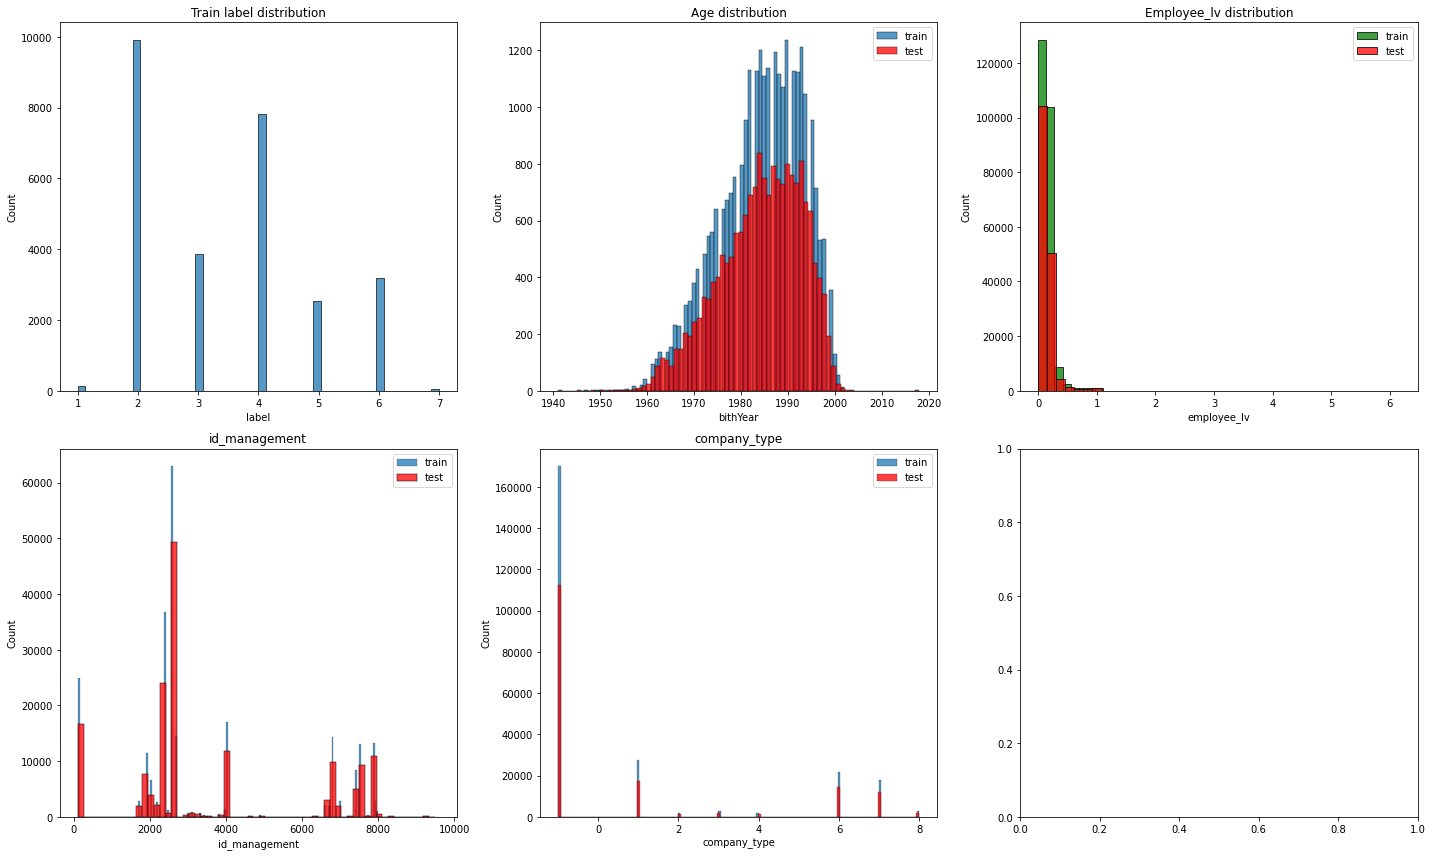

In [4]:
from sklearn.preprocessing import MinMaxScaler

fig, ax = plt.subplots(2, 3, figsize=(20, 12), tight_layout=True)

def scale_w_min_max(x, mi: float, ma: float):
    return (x - mi) / (ma - mi + 0.000000001)

ax[0][0].set_title('Train label distribution')
sns.histplot(label_train_df['label'], ax=ax[0][0])

ax[0][1].set_title('Age distribution')
sns.histplot(info_train_df['bithYear'], ax=ax[0][1], label='train')
sns.histplot(info_test_df['bithYear'], ax=ax[0][1], label='test', color='red')
ax[0][1].legend()

ax[0][2].set_title('Employee_lv distribution')
all_lv = work_train_df['employee_lv'].append(work_test_df['employee_lv'])
all_lv = all_lv[all_lv < 200]
print(all_lv.min(), all_lv.max())
sns.histplot(scale_w_min_max(work_train_df['employee_lv'], all_lv.min(), all_lv.max()), ax=ax[0][2], label='train', color='green', bins=40)
sns.histplot(scale_w_min_max(work_test_df['employee_lv'], all_lv.min(), all_lv.max()), ax=ax[0][2], label='test', color='red', bins=40)
# sns.histplot(work_train_df['employee_lv'], all_lv.min(), all_lv.max()), ax=ax[0][2], label='train')
# sns.histplot(work_test_df['employee_lv'], all_lv.min(), all_lv.max()), ax=ax[0][2], label='test', color='red')
ax[0][2].legend()

ax[1][0].set_title('id_management')
sns.histplot(work_train_df['id_management'], ax=ax[1][0], label='train')
sns.histplot(work_test_df['id_management'], ax=ax[1][0], label='test', color='red')
ax[1][0].legend()

ax[1][1].set_title('company_type')
sns.histplot(work_train_df['company_type'], ax=ax[1][1], label='train')
sns.histplot(work_test_df['company_type'], ax=ax[1][1], label='test', color='red')
ax[1][1].legend()

In [5]:
print('work_train.csv')
print('Number of unique id_bh: ',work_train_df['id_bh'].nunique())
print('Number of id_bh is not na:', len(work_train_df['id_bh'].notna()))
print('\nwork_test.csv')
print('Number of unique id_bh: ',work_test_df['id_bh'].nunique())
print('Number of id_bh is not na:', len(work_test_df['id_bh'].notna()))

work_train.csv
Number of unique id_bh:  27502
Number of id_bh is not na: 247559

work_test.csv
Number of unique id_bh:  18134
Number of id_bh is not na: 162283


In [6]:
def clean_job_role(job: str) -> str:
    job = str(job).lower()
    
    abbrev = {
        "nv": "nhân viên",
        "pgđ": "phó giám đốc",
        "gđ": "giám đốc",
        "gv": "giáo viên",
        "ct": "chủ tịch",
        "cn": "công nhân",
        "cv": "chuyên viên",
        "tgđ": "tổng giám đốc",
        "cb": "cán bộ",
        "sc": "sửa chữa",
        "bqt": "ban quản trị",
        "bv": "bảo vệ",
        "p.": "phó",
        "qt": "quản trị",
        "kd": "kinh doanh",
        "xd": "xây dựng",
        "sx": "sản xuất",
        "qhkh": "quan hệ khách hàng",
        "ts": "tiến sĩ",
        'í': 'í',
        'ậ': 'ậ',
        'ì': 'ì',
        'ợ': 'ợ',
        'ĩ': 'ĩ',
        'á': 'á',
        'ế': 'ế',
        'ố': 'ố',
        'ộ': 'ộ',
        'ð': 'đ',
        'sĩ': 'sỹ',
        'tóan': 'toán',
        'tòan': 'toán',
        'thuậ': 'thuật',
        'thuát': 'thuật',
        'cụng nhõn': 'công nhân',
        'giang vien': 'giảng viên',
        'nhấn viên': 'nhân viên',
        'n. viên': 'nhân viên',
        'vien': 'viên',
        'giáo dịch': 'giao dịch',
        'thủ quỷ': 'thủ quỹ',
        'qỹ': 'quỹ',
        'thu kho': 'thủ kho',
        'kĩ': 'kỹ',
        'kỷ': 'kỹ',
        'thuậtt': 'thuật',
        'ký sư': 'kỹ sư',
        'kê toán': 'kế toán',
        'toỏn': 'toán',
        'nhõn': 'nhân',
        'kếtoán': 'kế toán',
        'kê toán': 'kế toán',
        'viờn': 'viên',
        'k? toán': 'kế toán',
        'lãi xe': 'lái xe',
        'laí': 'lái',
        'laisi': 'lái',
        'dựoc': 'dược',
        'kế toan': 'kế toán',
        'ké toán': 'kế toán',
        'k.toán': 'kế toán',
        'giám điốc': 'giám đốc',
        'gíam': 'giám',
        'giam doc': 'giám đốc',
        'đóc': 'đốc',
        'giam đốc': 'giám đốc',
        'giám đôc': 'giám đốc',
        'giao viên': 'giáo viên',
        'giáo viêm': 'giáo viên',
        'giáo vên': 'giáo viên',
        'giaó viên': 'giáo viên',
        'giáo viêc': 'giáo viên',
        'giaos': 'giáo',
        'giáo đốc': 'giám đốc',
        'gíao': 'giáo',
        'giaso': 'giáo',
        'giỏo': 'giáo',
        'lao đông': 'lao động',
        'giám đèc': 'giám đốc',
        'giỏm đốc': 'giám đốc',
    }
    for k, v in abbrev.items():
        job = job.replace(k, v)

#     for k, v in abbrev.items():
#         if v in job:
#             job = v
        
    return job

    # HDND, to, phong, nhom, y, can bo, bi thu, technical, ky thuat, tram, lai, 
    # By Profession
    # Ky su, bao ve, executive, marketing, lai xe, y, giao vien, bac si, it, ke toan, ngan hang, duoc, giao vien,
    # By level
    # truong, pho, chinh, phu, quan ly, tro ly

In [7]:
display(work_train_df.sample(N))
print(len(work_train_df))
# Original: 28355
print(work_train_df['job/role'].nunique())

# Original: 28355
print(work_train_df['job/role'].map(clean_job_role).nunique())

# for name, count in work_train_df['job/role'].map(clean_job_role).value_counts().iteritems():
#     print(name, count)

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address
22054,5341,3314024311,3305,TE0002E,1,Công nhân vận hành máy may công nghiệp,20160100,20181200,7.0,Hưng Yên
171356,42406,7916266513,7900,QW0104Z,-1,Công nhân hàn điện công trình,20190100,20190800,11.0,NaN
73775,22664,2410012347,2400,NA0018A,7,Giáo viên,20101100,20130400,5.0,NaN
18027,4609,8707003071,3304,YN0095D,-1,Kỹ sư thủy lợi,20080200,20080300,3.0,Hưng Yên
16058,4119,7022255685,7408,YN0008H,-1,Công nhân phổ thông,20180600,20190200,11.0,Việt Nam


247559
28355
23930


In [8]:
all_df = info_train_df.join(work_train_df.set_index('id_bh'), on='id_bh', rsuffix='_work')
all_df = all_df.join(label_train_df.set_index('id_bh'), on='id_bh', rsuffix='_label')
display(all_df.sample(5))
display(all_df.describe())
# all_df.info()

,bithYear,gender,address,id_bh,id,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address_work,label
26349,1991,MALE,Vĩnh Phúc,2615008572,53082,2600,YN0161Z,-1,Công nhân sản xuất,20160100,20160200,7.0,Vĩnh Phúc,2
10440,1966,MALE,Bắc Giang,8499001714,24262,2402,FB0009Z,6,Văn phòng-Thống kê,20151000,20180300,9.0,Bắc Giang,4
13096,1989,MALE,Nghệ An,4014000109,28644,4013,NM11376,7,Nhân viên,20160100,20181200,5.0,Nghệ An,2
7710,1995,FEMALE,Nghệ An,1915830779,19721,1908,YN0002H,-1,Nhân viên sản xuất,20160300,20180200,9.0,Thái Nguyên,4
23294,1986,MALE,Vĩnh Phúc,2610004893,48100,2600,TZ0016Z,1,Công nhân,20090900,20100200,2.0,Vĩnh Phúc,5


,bithYear,id_bh,id,id_management,company_type,from_date,to_date,employee_lv,label
count,247559.000000,2.475590e+05,247559.000000,247559.000000,247559.000000,2.475590e+05,2.475590e+05,247554.000000,247559.000000
mean,1983.220949,3.918404e+09,30907.532806,3553.575059,0.642344,2.014830e+07,2.015701e+07,8.109002,3.817652
std,8.750181,2.766890e+09,15640.046730,2361.390558,2.852458,5.792714e+04,5.538154e+04,7.025556,1.440746
min,1941.000000,1.000007e+08,1.000000,100.000000,-1.000000,1.971080e+07,1.977100e+07,-1.000000,1.000000
25%,1977.000000,2.408013e+09,20494.500000,2400.000000,-1.000000,2.012030e+07,2.013060e+07,5.000000,2.000000
50%,1984.000000,2.616134e+09,31084.000000,2600.000000,-1.000000,2.016100e+07,2.017070e+07,7.000000,4.000000
75%,1990.000000,6.822815e+09,44718.000000,4020.000000,1.000000,2.019030e+07,2.020030e+07,9.000000,5.000000
max,2002.000000,9.820174e+09,55008.000000,9600.000000,8.000000,2.022040e+07,2.031100e+07,331.000000,7.000000


In [9]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247559 entries, 0 to 27501
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   bithYear       247559 non-null  int64  
 1   gender         247559 non-null  object 
 2   address        142906 non-null  object 
 3   id_bh          247559 non-null  int64  
 4   id             247559 non-null  int64  
 5   id_management  247559 non-null  int64  
 6   id_office      235391 non-null  object 
 7   company_type   247559 non-null  int64  
 8   job/role       214102 non-null  object 
 9   from_date      247559 non-null  int64  
 10  to_date        247559 non-null  int64  
 11  employee_lv    247554 non-null  float64
 12  address_work   183528 non-null  object 
 13  label          247559 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 28.3+ MB


In [10]:
def extract_year(x):
    try:
        return int(str(x)[:4])
    except:
        return None
    
def extract_month(x):
    try:
        return int(str(x)[4:6])
    except:
        return None

all_df['from_year'] = all_df['from_date'].map(extract_year)
all_df['from_month'] = all_df['from_date'].map(extract_month)
all_df['to_year'] = all_df['to_date'].map(extract_year)
all_df['to_month'] = all_df['to_date'].map(extract_month)
all_df.head()

,bithYear,gender,address,id_bh,id,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address_work,label,from_year,from_month,to_year,to_month
0,1971,MALE,hà Nội,113039360,1,106,TF2212F,-1,Giám đốc,20130100,20151200,7.0,Hà Nội,4,2013,1,2015,12
0,1971,MALE,hà Nội,113039360,1,106,TF2212F,-1,Giám đốc,20160100,20220400,10.0,Hà Nội,4,2016,1,2022,4
1,1993,FEMALE,Thành phố Hà Nội,116074930,2,102,TB16010,-1,Nhân viên lễ tân,20160600,20161200,7.0,Hà Nội,2,2016,6,2016,12
1,1993,FEMALE,Thành phố Hà Nội,116074930,2,102,TB16010,-1,Nhân viên lễ tân,20170100,20170300,8.0,Hà Nội,2,2017,1,2017,3
1,1993,FEMALE,Thành phố Hà Nội,116074930,2,102,NaN,-1,NaN,20170400,20170700,-1.0,NaN,2,2017,4,2017,7


In [11]:
all_df['id_bh'].value_counts()

2196007892    58
8401000539    44
2196007515    44
8398003594    41
2717077619    40
              ..
1716013813     1
116347745      1
2220984732     1
2416016895     1
121908876      1
Name: id_bh, Length: 27502, dtype: int64

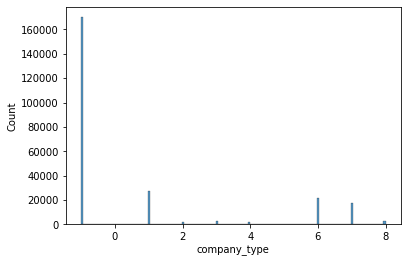

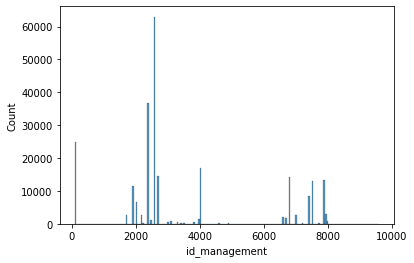

12740

In [12]:
plt.figure()
sns.histplot(all_df['company_type'])
plt.show()

plt.figure()
sns.histplot(all_df['id_management'])
plt.show()

# all_df['id_office'].value_counts().sort_index().plot(kind='bar')
# number of unique values in 'id_office'
all_df['id_office'].nunique()

In [13]:
def remove_accent(text: str) -> str:
    import unidecode
    return unidecode.unidecode(text)

def basic_clean(address: str) -> str:
    address = address.lower().rstrip().lstrip()
    remove_words = [
        'tỉnh', 't.', 'tp', 'tx', 'quận', 'huyện', 'huyện', 'thành phố', 'thành phó', 'thị xã', 'tphố', 'thànhphố', 'phố',
    ]
    for w in remove_words:
        # if 'tỉnh' in address:
        #     print(address)
            
        address = address.replace(w, '')
    
    # This affects the ones behind it
    address = address.replace(' ', '')
    address = address.replace('.', '')
    
    return address


def to_city(address: str) -> str:
    mapping: dict = {
        'hàđông': 'hànội',
        'keangnam': 'hànội',
        'số20núitrúc': 'hànội',
        'nhânchính': 'hànội',
        'haibàtrưnghn': 'hànội',
        'từliêm_hànội': 'hànội',
        'ngõ668đườnglạclongquân': 'hànội',
        'ngoc133nguyễntrãi': 'hànội',
        'nghĩatân': 'hànội',
        'ngõ210đườngngọchồi': 'hànội',
        'ngách1/4phốđịnhcông': 'hànội',
        'phốhuế': 'hànội',
        'số609trươngđịnh': 'hànội',
        'ngõ49huỳnhthúckháng': 'hànội',
        'r5khuđôthịroyalcity72nguyễntrãi': 'hànội',
        'cầutrắng': 'hànội',
        'kđtlinhđàm': 'hànội',
        'khuđôthịmớidịchvọng': 'hànội',
        
        # 'haibàtrưnghànội': 'hànội',
        'hạlong': 'quảngninh',
    }
    
    HNOI_DISTRICT = ['Hoàn Kiếm', 'Đống Đa', 'Ba Đình', 'Hai Bà Trưng', 'Hoàng Mai', 'Thanh Xuân', 'Long Biên', 'Nam Từ Liêm', 'Bắc Từ Liêm', 'Tây Hồ', 'Cầu Giấy', 'Hà Đông', 'câùgiấy']
    for district in HNOI_DISTRICT:
        if basic_clean(district) in address:
            return 'hànội'
        
        mapping[basic_clean(district)] = 'hànội'
        
    CITIES = [
        'nan', 'vĩnhphúc', 'bắcgiang', 'nghệan', 'hànội', 'tháinguyên',
        'lâmđồng', 'lạngsơn', 'đăklăk', 'quảngninh', 'phúthọ', 'hòabình',
        'bìnhphước', 'đăknông', 'bắcninh', 'tháibình', 'namđịnh', 'đàlạt',
        'thanhhóa', 'hảidương', 'hàtây', 'quỳnhlưu', 'yênbái', 'thanhhoá',
        'hàtĩnh', 'hànam', 'hồchíminh', 'tuyênquang', 'hưngyên', 'vĩnhphú',
        'hảiphòng', 'ninhbình', 'đồngnai', 'bảolộc', 'diễnchâu', 'caobằng',
        'bắckạn', 'hàbắc', 'đôlương', 'quảngngãi', 'hàgiang', 'bìnhđịnh',
        'bìnhdương', 'hạlong', 'sơnla', 'đứctrọng', 'huế', 'krôngpăc',
        'làocai', 'quảngbình', 'đồngtháp', 'quảngnam', 'phúyên',
        'hđôlương', 'bàrịavũngtàu', 'yênthế', 'angiang', 'khánhhòa',
        'bảolộclâmđồng', 'quảngtrị'
    ]
    
    for city in CITIES:
        if city in address:
            return city

    return mapping.get(address, address)


def clean_address(address: str) -> str:
    address = str(address)
    address = basic_clean(address)
        
    abbrev = {
        'hn': 'hànội',
        'hànôi': 'hànội',
        'hànôi': 'hànội',
        'hàn?i': 'hànội',
        'hànộ': 'hànội',
        'hànội': 'hànội',
        'hanoi': 'hànội',
        'hnội': 'hànội',
        
        'lđ': 'lâmđồng',
        'lamđồng': 'lâmđồng',
        'lâmđông': 'lâmđồng',
        'lâmđồn': 'lâmđồng',
        
        'bg': 'bắcgiang',
        'bắcgian': 'bắcgiang',
        'bắcgiangbg': 'bắcgiang',
        'tpbg': 'bắcgiang',
        'tbắcgiang': 'bắcgiang',
        'băcgiang': 'bắcgiang',
        'bácgiang': 'bắcgiang',
        '>bắcgiang': 'bắcgiang',
        'bắcgíang': 'bắcgiang',
        'bắcgiag': 'bắcgiang',
        
        'bp': 'bìnhphước',
        'bỡnhphước': 'bìnhphước',
        
        'hb': 'hòabình',
        'thòabình': 'hòabình',
        'hoàbình': 'hòabình',
        
        'vp': 'vĩnhphúc',
        'vĩnhphỳc': 'vĩnhphúc',
        'vĩnhphúcc': 'vĩnhphúc',
        
        'tn': 'tháinguyên',
        'tháinguyêntháinguyên': 'tháinguyên',
        
        'qn': 'quảngngãi', # OR 'quangninh' ??????
        'qninh': 'quảngninh',
        
        'đt': 'đồngtháp',
        
        'bt': 'bìnhthuận',
        
        'bmt': 'buônmêthuật',
        
        'tthuế': 'huế',
        
        'brvt': 'bàrịavũngtàu',
        'vũngtàu': 'bàrịavũngtàu',
        
        'tphcm': 'hồchíminh',
        'hcm': 'hồchíminh',
        
        'hưngyờn': 'hưngyên',
        
        'ngệan': 'nghệan',
        'nghêan': 'nghệan',
        'nghệa': 'nghệan',
        'nghean': 'nghệan',
        'nghêệan': 'nghệan',
        
        'bắccạn': 'bắckạn',
        'bắckan': 'bắckạn',
        
        'đắklắk': 'đăklăk',
        'đắclắk': 'đăklăk',
        'đắklắc': 'đăklăk',
        'đắclăk': 'đăklăk',
        'đắclắc': 'đăklăk',
        'dăklăk': 'đăklăk',
        'đăklắk': 'đăklăk',
        'đaklak': 'đăklăk',
        'daklak': 'đăklăk',
        'đắklăk': 'đăklăk',
        'đăklak': 'đăklăk',
        'đắkklắk': 'đăklăk',
        'dắklắk': 'đăklăk',
        'éắklắk': 'đăklăk',
        'đăklắc': 'đăklăk',
        'lắk': 'đăklăk',
        
        'đắknông': 'đăknông',
        'đắcnông': 'đăknông',
        'đaknông': 'đăknông',
        'đắcknông': 'đăknông',
        
        'qlưu': 'quỳnhlưu', # -> NGHE AN ????
        'hquỳnhlưu': 'quỳnhlưu',
        # 'quỳnhlưunghệan': '',
        # 'đôlươngnghệan': '',
        
        'krôngpăk': 'krôngpăc',
        
    }
    if address in abbrev:
        address = abbrev[address]
        
    for key in abbrev:
        if key in address:
            address = abbrev[key]

    # Clean again for abbrev
    # for w in remove_words:
    #     address = address.replace(w, '')
    address = address.lower().rstrip().lstrip()
    
    if all([x.isdigit() for x in address]):
        return 'number'
    
    return remove_accent(to_city(address))


In [14]:
def get_region(city: str) -> str:
    # https://xuyenvietmedia.com/blogs/kinh-doanh/7-vung-kinh-te-cua-viet-nam/#:~:text=C%C3%A1c%20t%E1%BB%89nh%20v%C3%A0%20th%C3%A0nh%20ph%E1%BB%91,t%E1%BB%95ng%20d%C3%A2n%20s%E1%BB%91%20c%E1%BA%A3%20n%C6%B0%E1%BB%9Bc.
    TRUNG_DU_MIEN_NUI_PHIA_BAC = [
        'hagiang', 'caobang', 'laocai', 'backan', 'langson', 'tuyenquang',
        'yenbai', 'thainguyen', 'phutho', 'bacgiang', 'laichau', 'dienbien',
        'sonla', 'hoabinh'
    ]
    DONG_BANG_PHIA_BAC = [
        'hanoi', 'haiphong', 'bacninh', 'hanam', 'haiduong', 'hungyen',
        'namdinh', 'thaibinh', 'vinhphuc', 'hoabinh'
    ]
    BAC_TRUNG_BO = [
        'thanhhoa', 'nghean', 'hatinh', 'quangbinh', 'quangtri', 'hue'
    ]
    NAM_TRUNG_BO = [
        'danang', 'quangnam', 'quangngai', 'binhdinh', 'phuyen', 'khanhhoa',
        'binhthuan', 'ninhthuan'
    ]
    DONG_NAM_BO = [
        'hochiminh', 'bariavungtau', 'binhduong', 'binhphuoc', 'dongnai', 'tayninh'
    ]
    TAY_NGUYEN = [
        'kontum', 'gialai', 'daklak', 'daknong', 'lamdong'
    ]
    DBSCL = [
        'cantho', 'longan', 'tiengiang', 'bentre', 'vinhlong', 'travinh', 'haugiang',
        'soctrang', 'dongthap', 'angiang', 'kiengiang', 'baclieu', 'camau'
    ]
  
    # TRUNG_DU_MIEN_NUI_PHIA_BAC = map(clean_address, TRUNG_DU_MIEN_NUI_PHIA_BAC)
    # DONG_BANG_PHIA_BAC = map(clean_address, DONG_BANG_PHIA_BAC)
    # BAC_TRUNG_BO = map(clean_address, BAC_TRUNG_BO)
    # NAM_TRUNG_BO = map(clean_address, NAM_TRUNG_BO)
    # DONG_NAM_BO = map(clean_address, DONG_NAM_BO)
    # TAY_NGUYEN = map(clean_address, TAY_NGUYEN)
    # DBSCL = map(clean_address, DBSCL)
    # print(f"{list(TRUNG_DU_MIEN_NUI_PHIA_BAC)=}")
    # print(f"{list(DONG_BANG_PHIA_BAC)=}")
    # print(f"{list(BAC_TRUNG_BO)=}")
    # print(f"{list(NAM_TRUNG_BO)=}")
    # print(f"{list(DONG_NAM_BO)=}")
    # print(f"{list(TAY_NGUYEN)=}")
    # print(f"{list(DBSCL)=}")
    
    city = clean_address(city)
    arr = [
        TRUNG_DU_MIEN_NUI_PHIA_BAC,
        DONG_BANG_PHIA_BAC,
        BAC_TRUNG_BO,
        NAM_TRUNG_BO,
        TAY_NGUYEN,
        DONG_NAM_BO,
        DBSCL
    ]
    
    # for i, arr_ in enumerate(arr):
    #     if city in arr_:
    #         return i
    
    # return len(arr)
    
    if city in TRUNG_DU_MIEN_NUI_PHIA_BAC:
        return 'trung-du-mien-nui-phia-bac'
    elif city in DONG_BANG_PHIA_BAC:
        return 'dong-bang-phia-bac'
    elif city in BAC_TRUNG_BO:
        return 'bac-trung-bo'
    elif city in NAM_TRUNG_BO:
        return 'nam-trung-bo'
    elif city in TAY_NGUYEN:
        return 'tay-nguyen'
    elif city in DONG_NAM_BO:
        return 'dong-nam-bo'
    elif city in DBSCL:
        return 'dbscl'
    else:
        return ''

    
def get_city_rank(city: str) -> int:
    # https://vi.wikipedia.org/wiki/Danh_s%C3%A1ch_%C4%91%C6%A1n_v%E1%BB%8B_h%C3%A0nh_ch%C3%ADnh_Vi%E1%BB%87t_Nam_theo_GRDP_b%C3%ACnh_qu%C3%A2n_%C4%91%E1%BA%A7u_ng%C6%B0%E1%BB%9Di
    # https://www.gso.gov.vn/en/px-web/?pxid=E1129&theme=Health%2C%20Culture%2C%20Sport%20and%20Living%20standard
    city = clean_address(city)
    rank_df['city'] = rank_df['city'].map(clean_address)
    
    try:
        if city in rank_df['city'].values:
            return rank_df.loc[rank_df['city'] == city, 'rank'].values[0]
    except IndexError:
        pass
    
    return NOT_FOUND_RANK

# test = get_region('Hà Nội')
# info_train_df['region'] = info_train_df['address'].map(get_region)
# info_test_df['region'] = info_test_df['address'].map(get_region)
# info_train_df['rank'] = info_train_df['address'].map(get_city_rank)
# info_test_df['rank'] = info_test_df['address'].map(get_city_rank)

In [15]:
base: pd.Series = info_train_df['address'].append(info_test_df['address'])
address: pd.Series = base
print(f"Base Distinct values: ", address.value_counts().count())

    
cleaned_address: pd.Series = base.map(
    lambda x: clean_address(str(x)))
print(f"Cleaned Distinct values: ", cleaned_address.value_counts().count())


# 560 -> Only train - 458: combined
# cities = []
# for name, count in cleaned_address.value_counts().iteritems():
    # if len(name) > 5:
    #     continue
    # if count < 5 and len(name) > 0:
    #     continue
    # print(name, count)
    # cities.append(name)
    
# print(repr(np.array(cities)))

Base Distinct values:  1329
Cleaned Distinct values:  447


In [16]:
def scale(x):
    return (x - min(x)) / (max(x) - min(x) + 0.00001)

def extract_year(x):
    try:
        return int(str(x)[:4])
    except:
        return None
    
def extract_month(x):
    try:
        return int(str(x)[4:6])
    except:
        return None

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


def get_prefix (x):
    if len(str(x)) < 2:
        return ''
    return str(x)[:2]

def clean_work_info(work_df: pd.DataFrame):
    work_df['from_year'] = work_df['from_date'].apply(extract_year).astype('int')
    work_df['from_month'] = work_df['from_date'].apply(extract_month).astype('int')
    work_df['to_year'] = work_df['to_date'].apply(extract_year).astype('int')
    work_df['to_month'] = work_df['to_date'].apply(extract_month).astype('int')
    work_df['work_time'] = ((work_df['to_year'] - work_df['from_year']) * 12).astype('int')
    
    tmp:dict = {}
    
    for index,row in work_df.iterrows():
        if row['to_year'] == row['from_year'] :
            row['work_time'] += (row['to_month'] - row['from_month'])
        else:
            row['work_time'] += (row['to_month'] - (12 - row['from_month']) ) 
        if('id_bh' not in tmp):
            tmp['id_bh'] = 0
        else :
            tmp['id_bh'] += row['work_time']
        # print(row['work_time'])
    
    work_df.sort_values('to_date',inplace = True)
    work_df.drop_duplicates(subset=['id_bh'],keep = 'last',inplace=True)
    for index,row in work_df.iterrows():
        row['work_time'] = tmp['id_bh']

    work_df['cleaned_address'] = work_df['address'].map(clean_address)
    work_df['cleaned_job/role'] = work_df['job/role'].map(clean_job_role)
#     work_df['city_rank'] = work_df['cleaned_address'].map(get_city_rank)
#     work_df['region'] = work_df['cleaned_address'].map(get_region)
    work_df['prefix'] = work_df['id_office'].map(get_prefix)

    PROFESSION = [ "may", 'kỹ thuật', 'kỹ sư', 'bảo vệ', 'kế toán', 'sửa chữa', 'lái xe', 'lái', 'y', 'dược', 'technical', 'marketing', 'ngân hàng', 'it', 'giáo viên', 'công nhân', 'giảng viên', 'thạc sỹ', 'thư ký', 'thủ quỹ', 'thủ kho', 'giao dịch viên', 'lao động', 'giám sát', 'điều hành', 'điều dưỡng', 'bác sỹ',]
    for profession in PROFESSION:
        work_df[f"is_profession_{profession}"] = work_df['cleaned_job/role'].map(lambda x: (profession in x))
    
    LEVEL = [ 'cán bộ', 'chuyên viên', 'nhân viên', 'phó', 'trưởng', 'quản lý', 'trợ lý', 'chính', 'phụ', 'giám đốc','tổng', 'chủ tịch', 'quản trị', 'bí thư',]
    for level in LEVEL:
        work_df[f"is_level_{level}"] = work_df['cleaned_job/role'].map(lambda x: (level in x))
    
    SCOPE = ['ban', 'phòng', 'bộ', 'trạm', 'huyện', 'thị xã', 'tỉnh', 'ubnd',]
    for scope in SCOPE:
        work_df[f"is_scope_{scope}"] = work_df['cleaned_job/role'].map(lambda x: (scope in x))
    
    return work_df


def get_dataset():
    print("Loading data...")
    info_test_df: pd.DataFrame =  pd.read_csv(f'{BASE_PATH}/info_test.csv')
    info_train_df: pd.DataFrame =  pd.read_csv(f'{BASE_PATH}/info_train.csv')

    label_test_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/label_test.csv')
    label_train_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/label_train.csv')

    work_test_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/work_test.csv')
    work_train_df: pd.DataFrame = pd.read_csv(f'{BASE_PATH}/work_train.csv')
    
    print(f'Read data done!')
    # Custom columns
    # info_train_df['region'] = info_train_df['address'].map(get_region)
    # info_test_df['region'] = info_test_df['address'].map(get_region)
    # info_train_df['rank'] = info_train_df['address'].map(get_city_rank)
    # info_test_df['rank'] = info_test_df['address'].map(get_city_rank)
    print('Clean address...')
    info_train_df['cleaned_address'] = info_train_df['address'].map(clean_address)
    print('Clean info_train_df done')
    info_test_df['cleaned_address'] = info_test_df['address'].map(clean_address)
    print('Clean info_test_df done')
    work_train_df = clean_work_info(work_train_df)
    work_test_df = clean_work_info(work_test_df)
    
    # Join tables
    print("Join tables...")
    train_df = info_train_df.join(
        work_train_df.set_index('id_bh'), on='id_bh', rsuffix='_work').join(
            label_train_df.set_index('id_bh'), on='id_bh', rsuffix='_label')
    test_df = info_test_df.join(
        work_test_df.set_index('id_bh'), on='id_bh', rsuffix='_work')

    print(f'Join data done!')
    
    train_df['job/role'].fillna('', inplace=True)
    test_df['job/role'].fillna('', inplace=True)
    train_df['address_work'].astype('string').fillna('', inplace=True)
    test_df['address_work'].astype('string').fillna('', inplace=True)
    train_df['cleaned_address_work'].astype('string').fillna('', inplace=True)
    test_df['cleaned_address_work'].astype('string').fillna('', inplace=True)
    
    print(f'Fillna done!')
    train_df.drop(train_df[train_df['employee_lv']>60].index, inplace=True)
    test_df.drop(test_df[test_df['employee_lv']>60].index, inplace=True)
    train_df.drop('company_type', axis=1, inplace=True)
    test_df.drop('company_type', axis=1, inplace=True)
    print(f'Drop data done!')
    # display(train_df.head())
    # display(test_df.head())
    
    # Categorical fields should include both test and train
    full_df = pd.concat([train_df.drop(['label'], axis=1), test_df])

    # Custom boolean fields
    BOOL_FIELDS = [x for x in full_df.columns if x.startswith('is_')]
    CATEGORICAL_FIELDS = [
        'address', 'cleaned_address',
#         'region',
        'gender',
        'id_management', 'id_office', 'job/role', 'cleaned_job/role',
        'address_work', 'cleaned_address_work',
        'prefix',
        *BOOL_FIELDS
    ]
    
    for field in CATEGORICAL_FIELDS:
        label_encoder = LabelEncoder().fit(full_df[field])
        train_df[field] = label_encoder.transform(train_df[field])
        test_df[field] = label_encoder.transform(test_df[field])
#         print(f"{field=} done")
    
    NUMERIC_FIELDS = [
#         'city_rank',
        'bithYear', 'employee_lv', 'work_time'
    ]
    
    for field in NUMERIC_FIELDS:
        mi = min(full_df[field])
        ma = max(full_df[field])
        train_df[field] = train_df[field].map(lambda x: (x - mi) / (ma - mi + 0.00001))
        test_df[field] = test_df[field].map(lambda x: (x - mi) / (ma - mi + 0.00001))
#         print(f"{field=} done")
    
    return train_df, test_df, CATEGORICAL_FIELDS

In [18]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
def plot_pca(df: pd.DataFrame, feature_names: list, labels: np.ndarray, n_components: int = 2):
    pca = PCA(n_components=n_components)
    features = pca.fit_transform(info_train_df[feature_names])
    features = MinMaxScaler().fit_transform(features)
    df = pd.DataFrame()
    print(features.shape, labels.shape)
    
    if n_components == 2:
        df['x'] = features[:, 0]
        df['y'] = features[:, 1]
        df['labels'] = labels
        plt.figure()
        sns.scatterplot(data=df, x='x', y='y', hue='labels')
        plt.show()
    elif n_components == 3:
        fig: plt.Figure = plt.figure()
        ax = fig.add_subplot(projection='3d')
        fig.add_axes(ax)

        # get colormap from seaborn
        cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

        # plot
        sc = ax.scatter(features[:, 0], features[:, 1], features[: 2], c=labels, s=40, marker='o', alpha=1, cmap=cmap)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.show()

# plot_pca(info_train_df, ['bithYear', 'address', 'id_bh', 'gender', 'region', 'rank'], info_train_df['label'], 2)
# plot_pca(info_train_df, ['bithYear', 'address', 'id_bh', 'gender'], info_train_df['label'], 2)
# plot_pca(info_train_df, ['bithYear', 'address', 'id_bh', 'gender', 'region', 'rank'], info_train_df['label'], 3)

In [19]:
train, test, categorical_fields = get_dataset()
# display(train.head())
# display(test.head())

Loading data...
Read data done!
Clean address...
Clean info_train_df done
Clean info_test_df done
Join tables...
Join data done!
Fillna done!
Drop data done!


In [20]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27502 entries, 0 to 27501
Data columns (total 71 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bithYear                      27502 non-null  float64
 1   gender                        27502 non-null  int64  
 2   address                       27502 non-null  int64  
 3   id_bh                         27502 non-null  int64  
 4   cleaned_address               27502 non-null  int64  
 5   id                            27502 non-null  int64  
 6   id_management                 27502 non-null  int64  
 7   id_office                     27502 non-null  int64  
 8   job/role                      27502 non-null  int64  
 9   from_date                     27502 non-null  int64  
 10  to_date                       27502 non-null  int64  
 11  employee_lv                   27502 non-null  float64
 12  address_work                  27502 non-null  int64  
 13  f

In [21]:
params = {
    'max_depth': 8, 
    'learning_rate': 0.09, 
    'n_estimators': 10000, 
    'max_bin': 271, 
    'min_data_in_leaf': 417, 
    'l2_leaf_reg': 0.0002403681946051935, 
    'subsample': 0.8658782253625072,
    'early_stopping_rounds' : 200,
    'random_state': 42,
#     'leaf_estimation_method': 'Gradient',
    'bootstrap_type': 'Bernoulli',
    'objective': 'MultiClass',
    'verbose': 0,
    "eval_metric" : 'TotalF1',
    # "task_type" : "GPU",
    # "devices" : '0:1'
}


In [22]:
from sklearn.model_selection import train_test_split

X = train.drop(['label', 'id_bh', 'id'], axis=1)
y = train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import plot_roc_curve, auc, roc_curve, f1_score
clf = CatBoostClassifier(**params)

clf.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False,
    plot=True,
    cat_features=list(set([
            'address', 'cleaned_address', 'gender', 'address_work', 'id_management', 'id_office', 'job/role',
            'address_work', 'cleaned_address_work', 'cleaned_job/role',
            *categorical_fields,
        ]))
)
y_pred = clf.predict(X_val)
f1_score = f1_score(y_val, y_pred, average="weighted")
print(f1_score)
# preds_proba = clf.predict_proba(X_val)
# print(preds_proba)
print(clf.get_best_iteration())
print(clf.score(X_val, y_val))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9227063061854038
770
0.9234684602799491


In [24]:
test_data = test.drop(['id_bh', 'id'], axis=1)
# print(len(test_data.columns))
# print(len(features_full))
test_label = clf.predict(test_data).astype('int64')
test["label"] = test_label

sub = pd.read_csv("../input/uet-hackathon-2022-data-science/label_test.csv")
sub = sub.merge(test, on="id_bh")
sub = sub[["id_bh", "label"]]
sub.to_csv(f'./submission{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}.csv', index=False)
sub

,id_bh,label
0,113118886,2
1,2521527855,2
2,2421701111,2
3,2620332660,2
4,2905004143,6
...,...,...
18129,2717061671,5
18130,2612005193,6
18131,7916334833,3
18132,2616146670,4
